# Regression Model for [Project Name] Using Python version 09
### David Lowe
### April 12, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: [Sample Paragraph - The purpose of this project is to construct prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Boston Housing dataset is a classic regression situation where we are trying to predict the value of a continuous variable.]

INTRODUCTION: [Sample Paragraph - The dataset for this project originates from the UCI Machine Learning Repository. The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.]

ANALYSIS: [Sample Paragraph - The baseline performance of the machine learning algorithms achieved an average RMSE of 4.907. Two algorithms (Stochastic Gradient Boosting and eXtreme Gradient Boosting) achieved the top RMSE metrics after the first round of modeling. After a series of tuning trials, Stochastic Gradient Boosting turned in the top overall result and achieved an RMSE metric of 3.618. By using the optimized parameters, the Stochastic Gradient Boosting algorithm processed the testing dataset with a RMSE of 2.930, which was even better than the training data.

CONCLUSION: [Sample Paragraph - For this iteration, the Stochastic Gradient Boosting algorithm achieved the best overall results using the training and testing datasets. For this dataset, Stochastic Gradient Boosting should be considered for further modeling or production use.]

Dataset Used: Boston Housing Data Set

Dataset ML Model: Regression with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/housing]

One potential source of performance benchmarks: [https://www.kaggle.com/c/boston-housing]

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem

### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_USERNAME')
    password = os.environ.get('MAIL_PASSWORD')
    receiver = os.environ.get('RECEIVER_MAIL')
    if sender==None or password==None or receiver==None :
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = dest_file
colNames = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
xy_original_df = read_csv(inputFile, delim_whitespace=True, names=colNames, header=None, index_col=False)

In [5]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [6]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
xy_original_df = xy_original_df.rename(columns={'MEDV': 'targetVar'})

In [7]:
# We create training datasets (xy_train_df, x_train_df, y_train_df) for various visualization and cleaning/transformation operations
# We create testing datasets (x_test_df, y_test_df) for various visualization and cleaning/transformation operations
# Use 70% of the data to train the models and the remaining for testing/validation

if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]

validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
xy_train_df = pd.concat([x_train_df, y_train_df], axis=1)
print("xy_original_df.shape: {} xy_train_df.shape: {}".format(xy_original_df.shape, xy_train_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (506, 14) xy_train_df.shape: (354, 14)
x_train_df.shape: (354, 13) y_train_df.shape: (354,)
x_test_df.shape: (152, 13) y_test_df.shape: (152,)


### 1.d) Set up the key parameters to be used in the script

In [8]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [10]:
email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [11]:
xy_train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,targetVar
454,9.51363,0.0,18.10,0,0.713,6.728,94.1,2.4961,24,666.0,20.2,6.68,18.71,14.9
425,15.86030,0.0,18.10,0,0.679,5.896,95.4,1.9096,24,666.0,20.2,7.68,24.39,8.3
201,0.03445,82.5,2.03,0,0.415,6.162,38.4,6.2700,2,348.0,14.7,393.77,7.43,24.1
98,0.08187,0.0,2.89,0,0.445,7.820,36.9,3.4952,2,276.0,18.0,393.53,3.57,43.8
255,0.03548,80.0,3.64,0,0.392,5.876,19.1,9.2203,1,315.0,16.4,395.18,9.25,20.9


#### 2.a.ii) Dimensions of the dataset.

In [12]:
xy_train_df.shape

(354, 14)

#### 2.a.iii) Types of the attributes.

In [13]:
xy_train_df.info()
xy_train_df.dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 454 to 410
Data columns (total 14 columns):
CRIM         354 non-null float64
ZN           354 non-null float64
INDUS        354 non-null float64
CHAS         354 non-null int64
NOX          354 non-null float64
RM           354 non-null float64
AGE          354 non-null float64
DIS          354 non-null float64
RAD          354 non-null int64
TAX          354 non-null float64
PTRATIO      354 non-null float64
B            354 non-null float64
LSTAT        354 non-null float64
targetVar    354 non-null float64
dtypes: float64(12), int64(2)
memory usage: 41.5 KB


CRIM         float64
ZN           float64
INDUS        float64
CHAS           int64
NOX          float64
RM           float64
AGE          float64
DIS          float64
RAD            int64
TAX          float64
PTRATIO      float64
B            float64
LSTAT        float64
targetVar    float64
dtype: object

#### 2.a.iv) Statistical summary of all attributes.

In [14]:
xy_train_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,targetVar
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,3.984217,10.750000,11.333588,0.067797,0.560711,6.270404,69.294633,3.731001,9.864407,414.401130,18.543220,355.011582,12.885508,22.147740
std,9.429690,22.229337,6.842834,0.251752,0.121352,0.711688,28.358526,2.110669,8.921675,170.471742,2.170709,94.020427,7.073702,9.435372
min,0.010960,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082913,0.000000,5.190000,0.000000,0.448250,5.878250,45.725000,2.007400,4.000000,277.000000,17.400000,375.650000,7.347500,16.325000
50%,0.276150,0.000000,9.795000,0.000000,0.538000,6.200500,79.850000,2.935900,5.000000,349.500000,19.100000,390.815000,11.855000,20.750000
75%,3.991233,12.500000,18.100000,0.000000,0.647000,6.587250,94.375000,5.116700,24.000000,666.000000,20.200000,395.765000,17.117500,24.575000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.780000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,34.410000,50.000000


#### 2.a.v) Count missing values.

In [15]:
print('Number of NaN in the dataframe columns:\n', xy_train_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_train_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
targetVar    0
dtype: int64
Total number of NaN in the dataframe:  0


### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

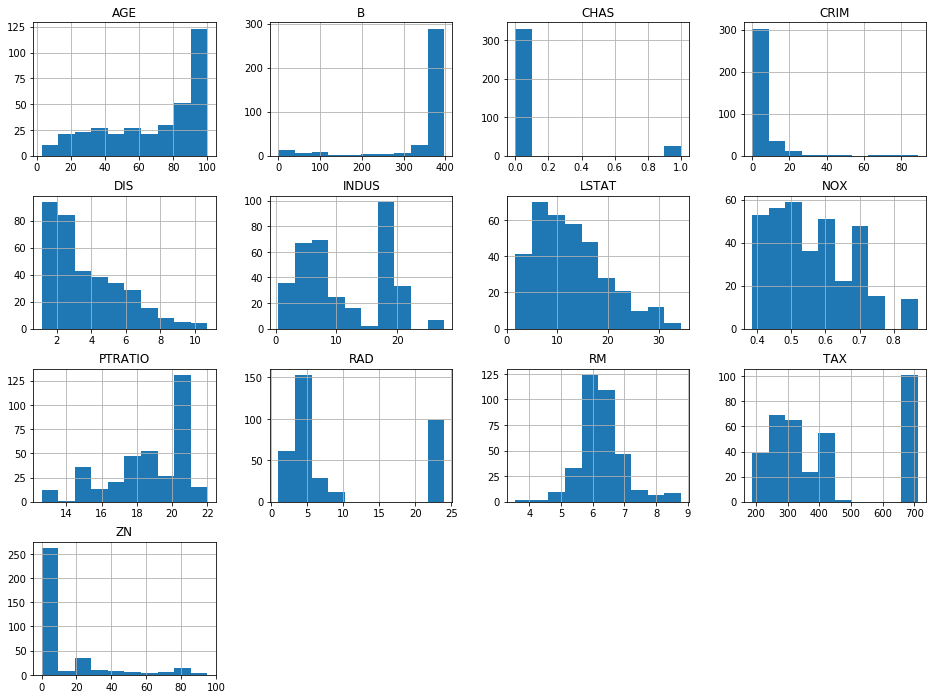

In [16]:
# Histograms for each attribute
x_train_df.hist()
pyplot.show()

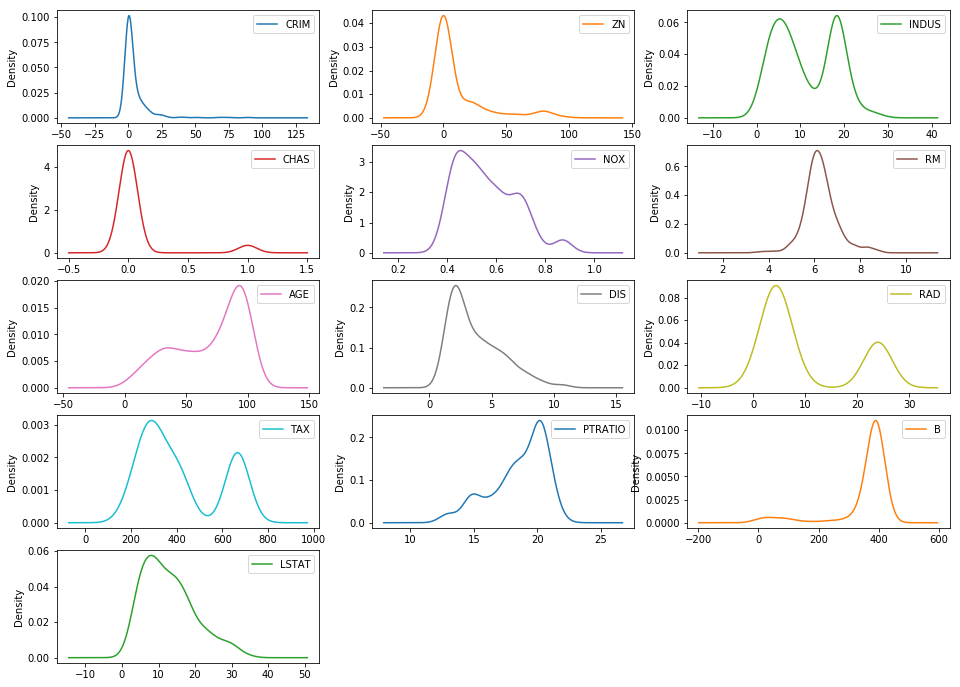

In [17]:
# Density plot for each attribute
x_train_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

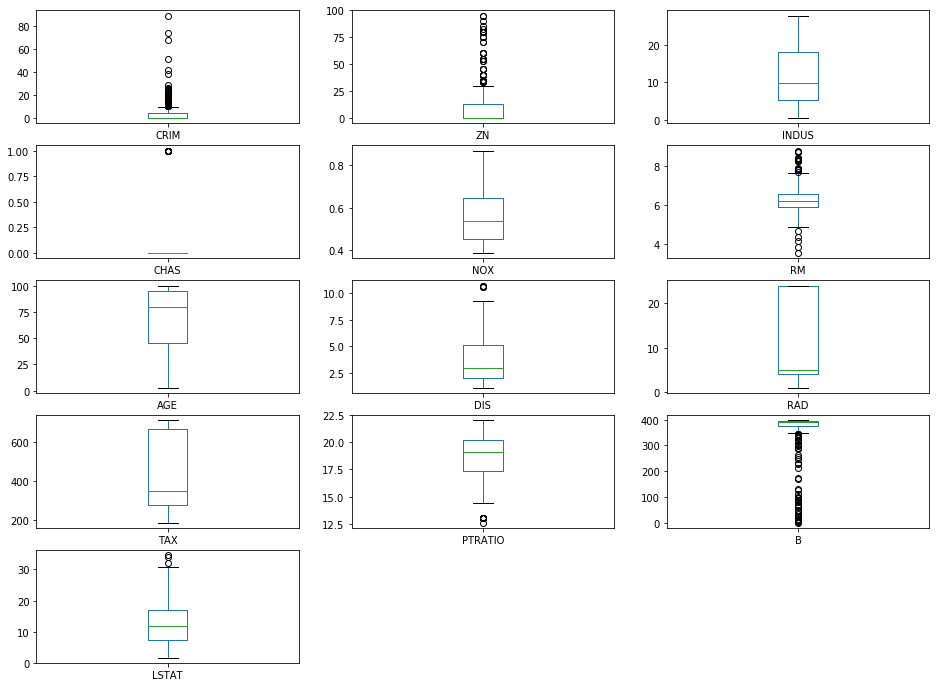

In [18]:
# Box and Whisker plot for each attribute
x_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol), sharex=False, sharey=False)
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [19]:
# Scatterplot matrix
# scatter_matrix(x_train_df)
# pyplot.show()

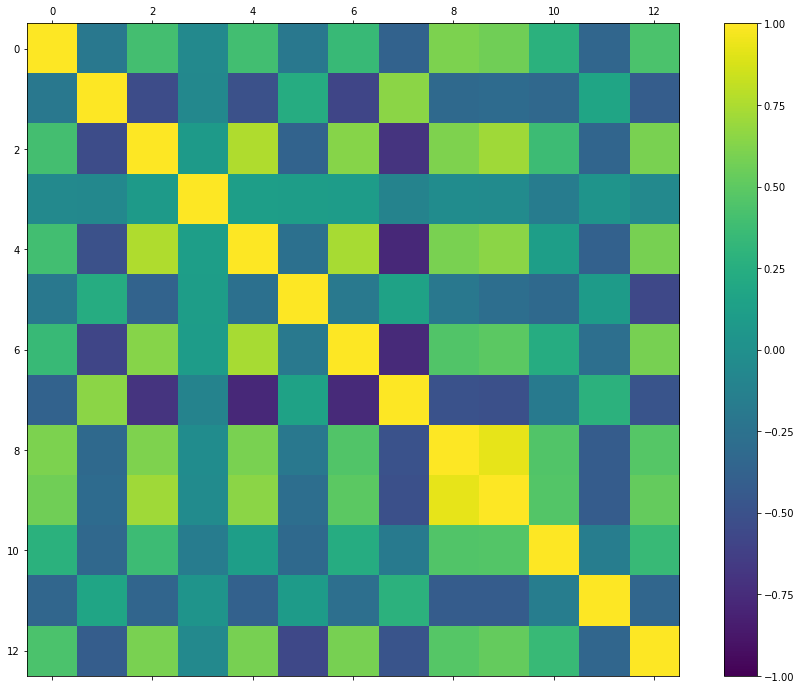

In [20]:
# Correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
correlations = x_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [21]:
email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [22]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Data Cleaning

In [23]:
# Not applicable for this iteration of the project
# Sample code for performing one-hot-encoding (Block #1 of 2)
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
# x_train_df = get_dummies(x_train_df)
# print(x_train_df.dtypes)

In [24]:
# Sample code for performing one-hot-encoding (Block #2 of 2)
# According to the data dictionary, columns SOME_ATTR should be converted to categorical type
# x_train_df['SOME_ATTR'] = x_train_df['SOME_ATTR'].astype('category')

# # Apply the One-Hot-Encoding (dummy variable handling) technique
# x_test_df = get_dummies(x_test_df)
# print(x_test_df.dtypes)

### 3.b) Feature Selection

In [25]:
# Not applicable for this iteration of the project
# Sample Code for finding collinear features (Block #1 of 3)
# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [26]:
# Sample Code for finding collinear features (Block #2 of 3)
# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = x_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [27]:
# Sample Code for finding collinear features (Block #3 of 3)
# Drop the highly collinear features
# x_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# x_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

In [28]:
# Not applicable for this iteration of the project
# Sample code for performing Attribute Importance Ranking (Block #1 of 3)
# Feature Importance with LASSO
# model = Lasso()
# model.fit(x_train_df, y_train_df)
# importanceScore = abs(model.coef_)
# attributeList = x_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [29]:
# Sample code for performing Attribute Importance Ranking (Block #2 of 3)
# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [30]:
# Sample code for performing Attribute Importance Ranking (Block #3 of 3)
# Removing the unselected attributes from the training and validation dataframes
# x_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# x_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [31]:
# Not applicable for this iteration of the project
# Sample code for performing Recursive Feature Elimination (Block #1 of 3)
# Using the LASSO algorithm, we perform the Recursive Feature Elimination (RFE) technique
# x_rfeVal = x_train.values
# y_rfeVal = y_train.values.ravel()
# estimator = Lasso(random_state=seedNum)
# selector = RFE(estimator, 40)
# selector = selector.fit(x_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The mask of selected features:\n',selector.ranking_)

In [32]:
# Sample code for performing Recursive Feature Elimination (Block #2 of 3)
# Remove the unselected attributes from the training dataframes
# x_train_df = x_train_df[x_train_df.columns[selector.support_]]
# print(x_train_df.shape)
# x_train_df.head()

In [33]:
# Sample code for performing Recursive Feature Elimination (Block #3 of 3)
# Remove the unselected attributes from the validation dataframes
# x_test_df = x_test_df[x_test_df.columns[selector.support_]]
# print(x_test_df.shape)
# x_test_df.head()

### 3.c) Data Transforms

In [34]:
# Not applicable for this iteration of the project
# Sample code for performing SMOTE transformation on the training data (Block #1 of 2)
# x_train_imbal = x_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("x_train_imbal.shape: {} y_train_imbal.shape: {}".format(x_train_imbal.shape, y_train_imbal.shape))

In [35]:
# Sample code for performing SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# sm = SMOTE(random_state=seedNum, sampling_strategy=1.0)
# x_train, y_train = sm.fit_sample(x_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.d) Display the Final Datasets for Model-Building

In [36]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

x_train.shape: (354, 13) y_train.shape: (354,)
x_test.shape: (152, 13) y_test.shape: (152,)


## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate four linear, two non-linear, and three ensemble algorithms:

Linear Algorithms: Linear Regression, Ridge Regression, LASSO Regression, and Elastic Net Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Random Forest, Extra Trees, and Stochastic Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [37]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'

In [38]:
# Set up Algorithms Spot-Checking Array
models = []
models.append(('LR', LinearRegression()))
models.append(('RR', Ridge()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(random_state=seedNum)))
models.append(('ET', ExtraTreesRegressor(random_state=seedNum)))
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
models.append(('XGB', XGBRegressor(random_state=seedNum)))
results = []
names = []
metrics = []

In [39]:
# Generate model in turn
for name, model in models:
	email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(metrics))

LR: -25.612033 (13.351275)
Model training time: 0:00:00.013966
RR: -25.790544 (13.693551)
Model training time: 0:00:00.017990
LASSO: -29.758615 (14.872414)
Model training time: 0:00:00.039973
EN: -29.428369 (14.921289)
Model training time: 0:00:00.012010
CART: -22.335966 (15.921982)
Model training time: 0:00:00.028912
KNN: -50.328254 (29.718809)
Model training time: 0:00:00.013974
RF: -14.965861 (11.658095)
Model training time: 0:00:00.185814
ET: -15.083016 (9.266903)
Model training time: 0:00:00.140938
GBM: -13.141921 (10.778444)
Model training time: 0:00:00.556680
XGB: -14.451082 (12.146391)
Model training time: 0:00:00.473677
Average metrics (neg_mean_squared_error) from all models: -24.089566129265233


### 4.b) Spot-checking baseline algorithms

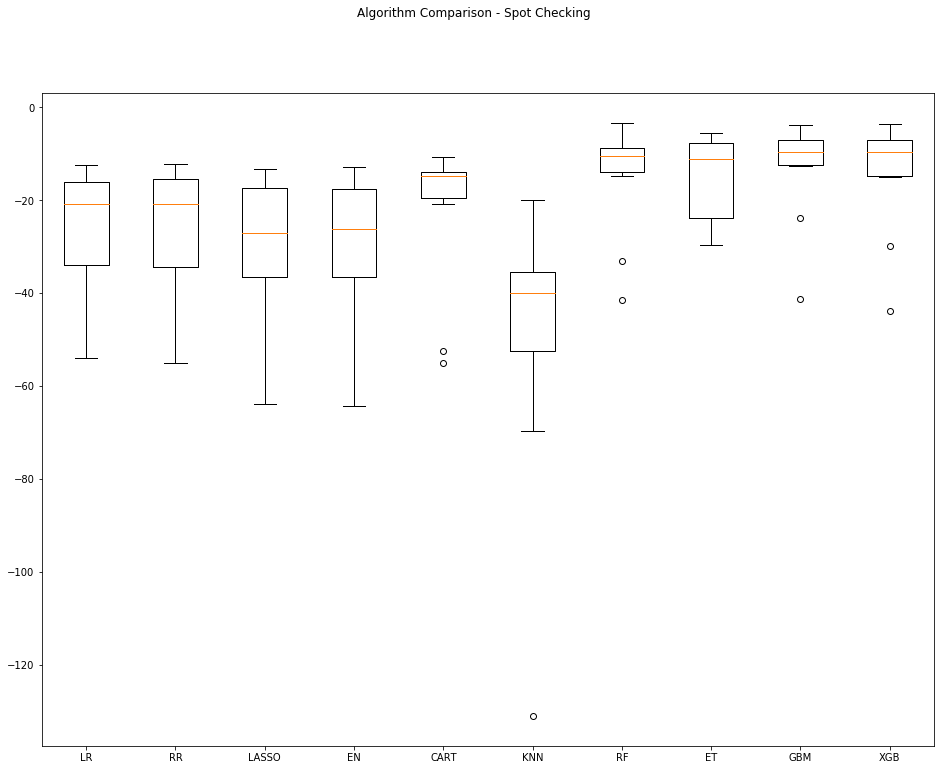

In [40]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [41]:
# Set up the comparison array
results = []
names = []

In [42]:
# Tuning algorithm #1 - eXtreme Gradient Boosting
email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(n_estimators=np.array([50,75,100,125,150]))
model1 = XGBRegressor(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('XGB')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

C:\Users\david.lowe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: -14.372014 using {'n_estimators': 125}
-15.187233 (12.623478) with: {'n_estimators': 50}
-14.677242 (12.188120) with: {'n_estimators': 75}
-14.389253 (12.099370) with: {'n_estimators': 100}
-14.372014 (11.945839) with: {'n_estimators': 125}
-14.388169 (11.852405) with: {'n_estimators': 150}
Model training time: 0:00:02.677467


In [43]:
# Tuning algorithm #2 - Stochastic Gradient Boosting
email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([50,75,100,125,150]))
model2 = GradientBoostingRegressor(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('GBM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

C:\Users\david.lowe\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: -13.089399 using {'n_estimators': 100}
-13.816059 (11.347471) with: {'n_estimators': 50}
-13.144224 (10.945430) with: {'n_estimators': 75}
-13.089399 (10.733070) with: {'n_estimators': 100}
-13.175620 (10.884590) with: {'n_estimators': 125}
-13.228649 (11.000794) with: {'n_estimators': 150}
Model training time: 0:00:02.209737


### 5.b) Compare Algorithms After Tuning

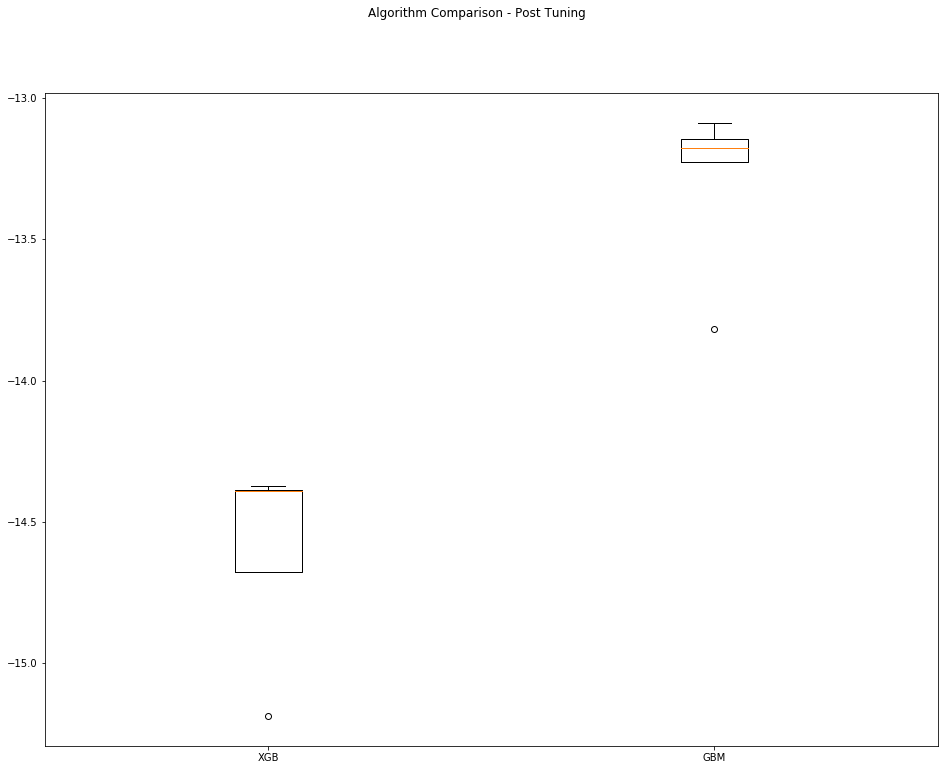

In [44]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [45]:
email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [46]:
model = GradientBoostingRegressor(n_estimators=100, random_state=seedNum)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(mean_squared_error(y_test, predictions))

8.587245063571602


### 6.b) Create standalone model on entire training dataset

In [47]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = GradientBoostingRegressor(n_estimators=100)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (506, 13) y_complete.shape: (506,)
Model training time: 0:00:00.076955


### 6.c) Save model for later use

In [48]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [49]:
email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:53.205708
